# **Electricity Consumption Using Time Series Analysis**



Here the **Objective** is- Build a model to forecast the electricity power consumtion(value. The data is classified in date/time and the value of consumption. The goal is to predict electricity consumption for the next 6 years i.e. till 2024.



**Loading the basic libraries**

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

**Loading Electric Production data set**

In [6]:
elecom = pd.read_csv('../input/electric-production/Electric_Production.csv')

**Let's check first 5 and last 5 records of data set**

In [7]:
elecom.head(5)

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


In [8]:
elecom.tail(5)

,DATE,Value
392,09-01-2017,98.6154
393,10-01-2017,93.6137
394,11-01-2017,97.3359
395,12-01-2017,114.7212
396,01-01-2018,129.4048


In [9]:
elecom.shape

(397, 2)

In [10]:
elecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    397 non-null    object 
 1   Value   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


**There are 397 records in datasets and 2 columns. There are no null records present. But, look at the DATE column. We need to convert them in to datetime datatype.**

In [14]:
from datetime import datetime
elecom['DATE']=pd.to_datetime(elecom['DATE'],infer_datetime_format=True)

In [15]:
elecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    397 non-null    datetime64[ns]
 1   Value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


**Now, we will need to index DATE column.**

In [16]:
elecomind = elecom.set_index('DATE',inplace=False)

In [17]:
elecomind.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


**Let's plot the data**

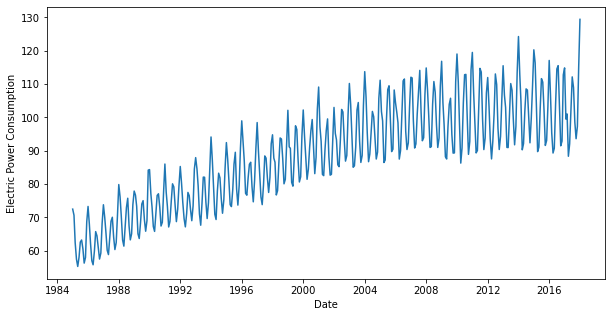

In [18]:
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Electric Power Consumption')
plt.plot(elecomind)

**From the above plot, we can see that there is a Trend compoenent in the series. Hence, we now check for stationarity of the data.**

**function consisting of stationary data checking and ADCF test working.**

In [20]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.figure(figsize=(10,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    elecom_test = adfuller(timeseries['Value'], autolag='AIC')
    dfoutput = pd.Series(elecom_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in elecom_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

**Let's determine & plot rolling statistics.**

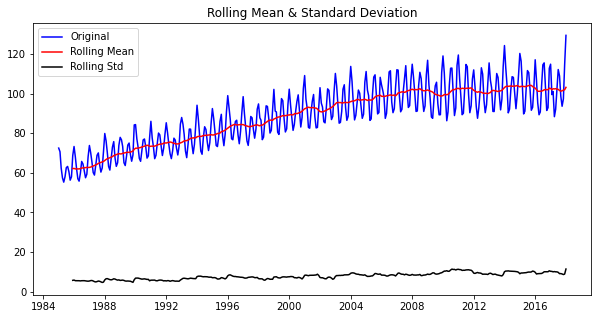

Results of Dickey Fuller Test:
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [21]:
test_stationarity(elecomind)

**From above plot, we can see that Rolling Mean itself has a trend component even though Rolling Standard Deviation is fairly constant with time.**

**For time series to be stationary, we need to ensure that both Rolling Mean and Rolling Standard Deviation remain fairly constant WRT time.**

**Both the curves needs to be parallel to X-Axis, in our case it is not so.**

**We've also conducted the ADCF ie Augmented Dickey Fuller Test. Having the Null Hypothesis to be Time Series is Non Stationary.**

For a Time series to be stationary, the ADCF test should have:

1. p-value should be low (according to the null hypothesis)
2. The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
From the above ADCF test result, we can see that p-value(near to 0.18) is very large. Also critical values lower than Test Statistics. Hence, we can safely say that our Time Series at the moment is **NOT STATIONARY**

### **Data Transformation To Achieve Stationarity**

Now, we will perform some data transformation to achieve Stationarity. We perform transformations like taking log scale, square, square root, cube, cube root, time shift, exponential decay, etc.

performing Log Transformation.

Basically we need to remove the trend component.

In [22]:
elecom_log = np.log(elecomind)

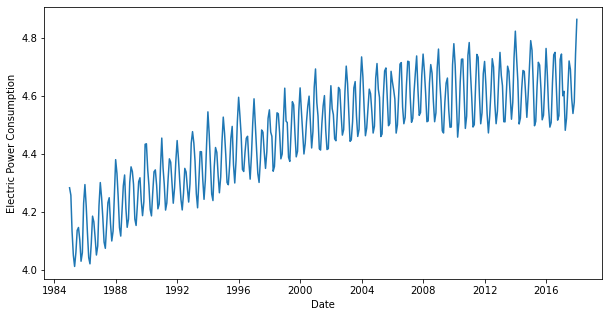

In [23]:
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Electric Power Consumption')
plt.plot(elecom_log)

**Rolling stats.**

In [24]:
rollmean_log = elecom_log.rolling(window=12).mean()
rollstd_log = elecom_log.rolling(window=12).std()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithmic Scale)')

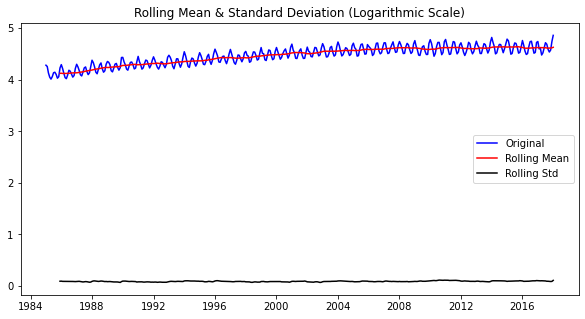

In [25]:
plt.figure(figsize=(10,5))
plt.plot(elecom_log, color='blue', label='Original')
plt.plot(rollmean_log, color='red', label='Rolling Mean')
plt.plot(rollstd_log, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Logarithmic Scale)')

From above graph we can say that, we slightly bettered our previous results. Now, we are heading into the right direction.

From the above graph, Time series with log scale as well as Rolling Mean(moving avg) both have the trend component. Thus subtracting one from the other should remove the trend component.

**R (result) = Time Series Log Scale - Rolling Mean Log Scale -> this can be our final non trend curve.**

In [26]:
elecom_new = elecom_log - rollmean_log

In [27]:
elecom_new.head()

,Value
DATE,
1985-01-01,NaN
1985-02-01,NaN
1985-03-01,NaN
1985-04-01,NaN
1985-05-01,NaN


In [28]:
elecom_new.dropna(inplace=True)

In [29]:
elecom_new.head()

,Value
DATE,
1985-12-01,0.103961
1986-01-01,0.167724
1986-02-01,0.095629
1986-03-01,0.007329
1986-04-01,-0.079115


**Let's determine & plot rolling statistics.**

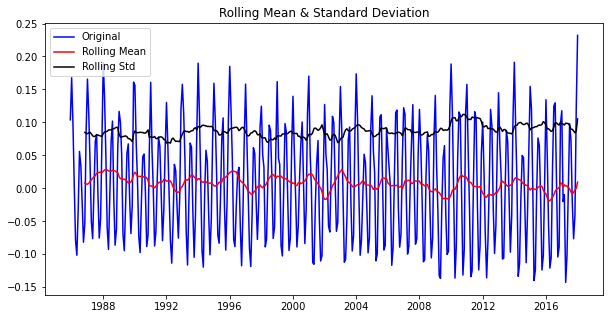

Results of Dickey Fuller Test:
Test Statistic                  -5.211586
p-value                          0.000008
#Lags Used                      15.000000
Number of Observations Used    370.000000
Critical Value (1%)             -3.448148
Critical Value (5%)             -2.869383
Critical Value (10%)            -2.570948
dtype: float64


In [30]:
test_stationarity(elecom_new)

**From the above plot, we came to know that "indeed subtracting two related series having similar trend components actually removed trend and made the dataset stationary"**

Also, after concluding the results from ADFC test, we can now say that given series is now STATIONARY

### **Time Shift Transformation**

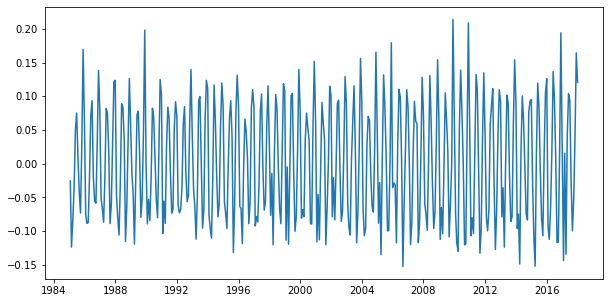

In [31]:
elecom_log_diff = elecom_log - elecom_log.shift()
plt.figure(figsize=(10,5))
plt.plot(elecom_log_diff)

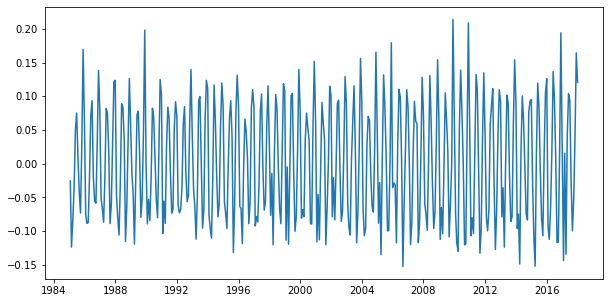

In [32]:
elecom_log_diff.dropna(inplace=True)
plt.figure(figsize=(10,5))
plt.plot(elecom_log_diff)

**Let's determine & plot rolling statistics.**

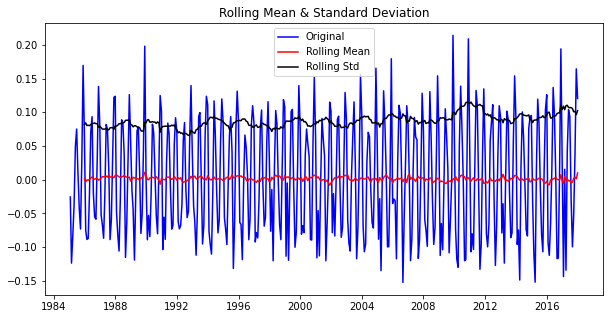

Results of Dickey Fuller Test:
Test Statistic                -6.748333e+00
p-value                        2.995161e-09
#Lags Used                     1.400000e+01
Number of Observations Used    3.810000e+02
Critical Value (1%)           -3.447631e+00
Critical Value (5%)           -2.869156e+00
Critical Value (10%)          -2.570827e+00
dtype: float64


In [33]:
test_stationarity(elecom_log_diff)

From above plot, we can see that, visually this is the very best result as our series along with rolling stats values of moving avg(mean) & moving standard deviation is very much flat & stationary.

**break down the 3 components of the log scale series**

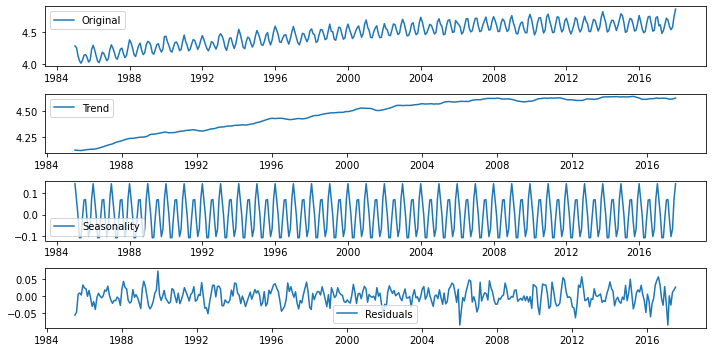

In [34]:
decomposition = seasonal_decompose(elecom_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(elecom_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

**remove NaN**

In [35]:
elecom_decompose = residual
elecom_decompose.dropna(inplace=True)

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

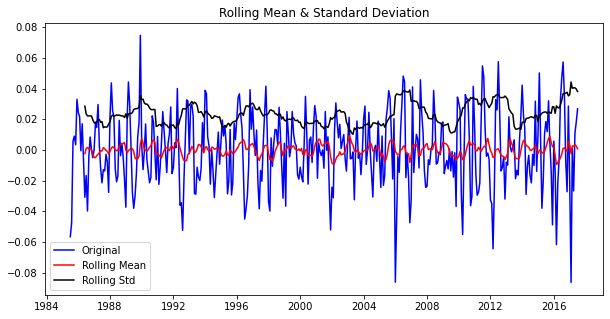

In [36]:
rollmean_decompose = elecom_decompose.rolling(window=12).mean()
rollstd_decompose = elecom_decompose.rolling(window=12).std()

plt.figure(figsize=(10,5))
plt.plot(elecom_decompose, color='blue', label='Original')
plt.plot(rollmean_decompose, color='red', label='Rolling Mean')
plt.plot(rollstd_decompose, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

### **Plotting ACF & PACF**

In [37]:
lag_acf = acf(elecom_log_diff, nlags=20)
lag_pacf = pacf(elecom_log_diff, nlags=20, method='ols')

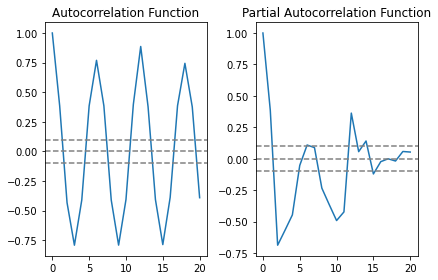

In [38]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(elecom_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(elecom_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(elecom_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(elecom_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

From the ACF graph, we can see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 3 From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 3

(from the above graphs the p and q values are very close to 3 where the graph cuts off the origin)

**ARIMA is AR + I + MA.** .

### **AR Model**
Making order = (3,1,0)

Plotting AR model


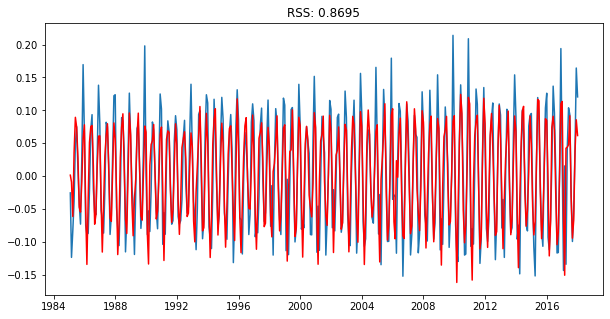

In [39]:
model1 = ARIMA(elecom_log, order=(3,1,0))
results_AR = model1.fit(disp=-1)
plt.figure(figsize=(10,5))
plt.plot(elecom_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - elecom_log_diff['Value'])**2))
print('Plotting AR model')

### **MA Model**
Making order = (0,1,3)

Plotting MA model


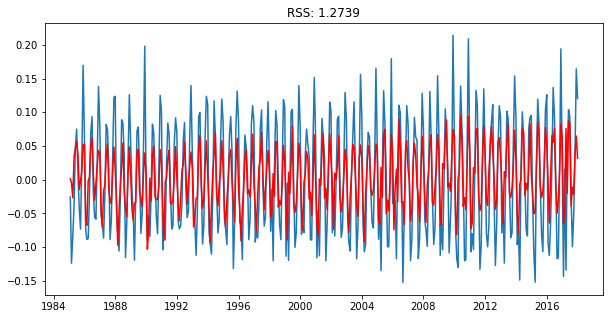

In [40]:
model2 = ARIMA(elecom_log, order=(0,1,3))
plt.figure(figsize=(10,5))
results_MA = model2.fit(disp=-1)
plt.plot(elecom_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - elecom_log_diff['Value'])**2))
print('Plotting MA model')

### **AR+I+MA = ARIMA Model**
Making order = (3,1,3)

Plotting ARIMA model


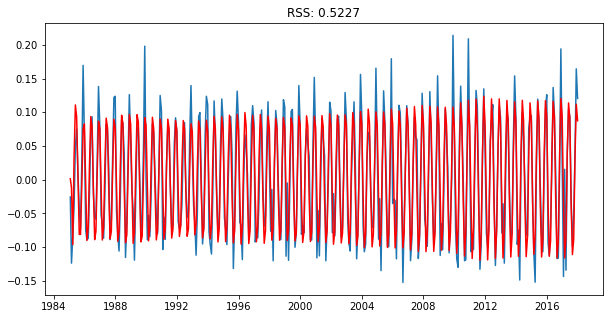

In [41]:
model = ARIMA(elecom_log, order=(3,1,3))
plt.figure(figsize=(10,5))
results_ARIMA = model.fit(disp=-1)
plt.plot(elecom_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - elecom_log_diff['Value'])**2))
print('Plotting ARIMA model')

**RSS value for:** AR Model - 0.8695, MA Model - 1.2793

ARIMA Model - 0.5227

By combining AR & MA into ARIMA, we see that RSS value has decreased from either case to 0.5227, indicating ARIMA to be better than its individual component models.



### **Prediction & Reverse Transformation**

In [42]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

DATE
1985-02-01    0.001414
1985-03-01   -0.012055
1985-04-01   -0.096091
1985-05-01    0.032718
1985-06-01    0.110825
dtype: float64

In [43]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

DATE
1985-02-01    0.001414
1985-03-01   -0.010641
1985-04-01   -0.106732
1985-05-01   -0.074014
1985-06-01    0.036811
dtype: float64

In [44]:
predictions_ARIMA_log = pd.Series(elecom_log['Value'].iloc[0], index=elecom_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

DATE
1985-01-01    4.283658
1985-02-01    4.285072
1985-03-01    4.273018
1985-04-01    4.176926
1985-05-01    4.209644
dtype: float64

### **Inverse of log is exp**

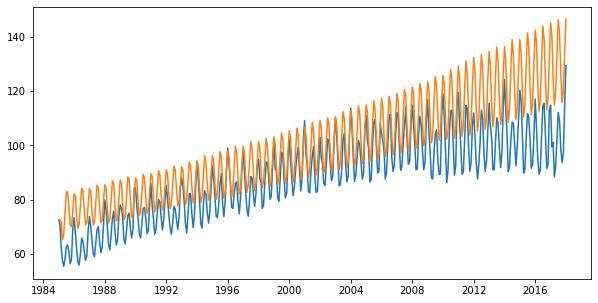

In [45]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(10,5))
plt.plot(elecomind)
plt.plot(predictions_ARIMA)

**From above plot, we can see that our predicted forecasts are very close to the real time series values. It also indicates a fairly accurate model.**

In [46]:
elecom_log.head()

,Value
DATE,
1985-01-01,4.283658
1985-02-01,4.258049
1985-03-01,4.134369
1985-04-01,4.051287
1985-05-01,4.013046


In [47]:
elecom_log.shape

(397, 1)

** 396 (existing data of 33 yrs in months) data points. forecast for additional 6 yrs (6x12 months=72 data points).**

**396+72 = 468 records/data points**

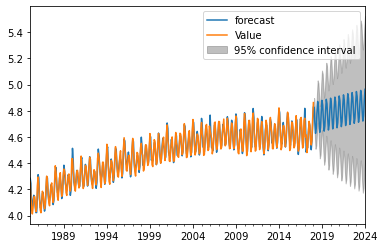

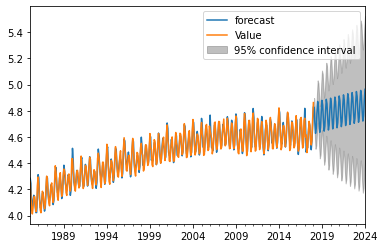

In [48]:
results_ARIMA.plot_predict(1,468)